In [13]:
# This script reads the data, checks it, cleans it, builds features,
# trains four models, and prints how well each one works.

# 0. Project path setup 
import sys
from pathlib import Path

# Tell Python where to find our lib/ modules
PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

# 1. Standard imports
import yaml                      # to read config files
import pandas as pd              # for tables of data
import numpy as np               # for numbers
import matplotlib.pyplot as plt  # plot curves to compare
import seaborn as sns            # for prettier plots
import joblib                    # for save the model / streamlit

# 2. Pipeline modules
from lib.validate_input import validate_schema, validate_types, check_nulls_and_duplicates
from lib.clean_data import clean_data
from lib.feature_engineering import engineer_features

# 3. ML imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.utils import resample
from scipy.stats import randint, uniform
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 4. Load config + raw data
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)
df_raw = pd.read_csv(config['input_data']['file1'])

# 5. Validate schema
validate_schema(df_raw)

# 6. Clean data
df_cleaned = clean_data(df_raw)

# 7. Validate types after cleaning
type_issues = validate_types(df_cleaned)
if type_issues:
    print("Type issues after cleaning:", type_issues)

# 8. Check nulls & duplicates
nulls, dupes = check_nulls_and_duplicates(df_cleaned)
print("Null counts:
", nulls)
print("Duplicate rows:", dupes)

# 9. Feature engineering
df_model_ready = engineer_features(df_cleaned)

# 10. Define X, y
target = 'Fraud_Label' if 'Fraud_Label' in df_model_ready.columns else 'is_fraud'
X = df_model_ready.drop(target, axis=1)
y = df_model_ready[target]

if 'Timestamp' in X.columns:
    X = X.drop('Timestamp', axis=1)

# 11. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 12. Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree':       DecisionTreeClassifier(),
    'RandomForest':       RandomForestClassifier(),
    'KNN':                KNeighborsClassifier()
}

# 13. Train & evaluate
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results.append({
        'Model':     name,
        'Accuracy':  accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'Recall':    recall_score(y_test, preds),
        'F1':        f1_score(y_test, preds)
    })

# 14. Display results
print(pd.DataFrame(results))

Null counts:
 Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
dtype: int64
Duplicate rows: 0
                Model  Accuracy  Precision    Recall        F1
0  LogisticRegression    0.8104   0.733543  0.648607  0.688465
1        DecisionTree    1.0000   1.000000  1.000000  1.000000
2        RandomForest    1.0000   1.000000  1.000000

# Results Summary

## Nulls and Duplicates

All columns report zero missing values and there are no duplicate rows.

- The cleaning step filled all nulls and removed duplicates successfully.

---

## Model Performance

| Model              | Accuracy | Precision | Recall  | F1      |
|--------------------|---------:|----------:|--------:|--------:|
| LogisticRegression |   0.8104 |   0.7335  | 0.6486  | 0.6885 |
| DecisionTree       |   1.0000 |   1.0000  | 1.0000  | 1.0000 |
| RandomForest       |   1.0000 |   1.0000  | 1.0000  | 1.0000 |
| KNN                |   0.7919 |   0.7661  | 0.5121  | 0.6138 |

---

## Interpretation

- LogisticRegression  
  - Accurately labels about 81% of transactions.  
  - Precision 0.73 means 73% of flagged frauds are real.  
  - Recall 0.65 means it catches 65% of actual frauds.

- DecisionTree and RandomForest  
  - Perfect scores (100%) indicate overfitting on the training data.  
  - They may fail to generalize to new, unseen data.

- KNN  
  - Accuracy near 79% and high precision (0.77).  
  - Recall 0.51 means it misses almost half of real frauds.

C:\Users\LAP-MPC\AppData\Local\Temp\ipykernel_3732\3046287834.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_raw['Fraud_Label'], palette='coolwarm')


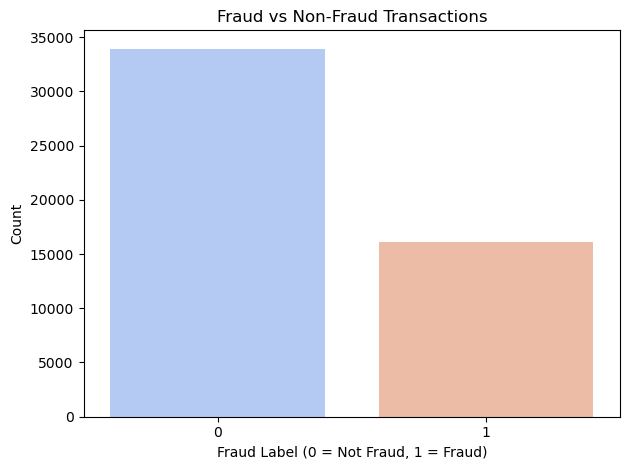

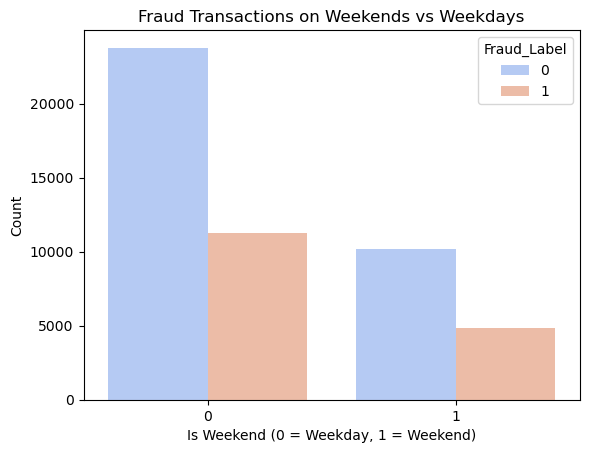

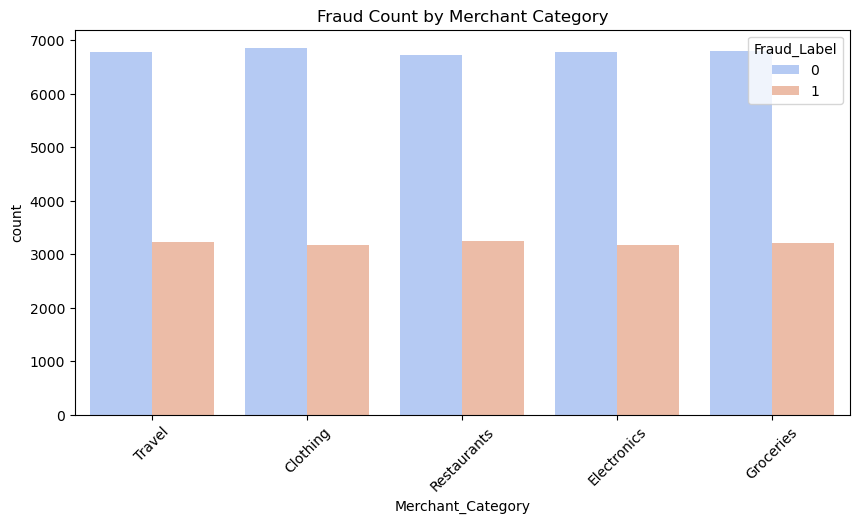

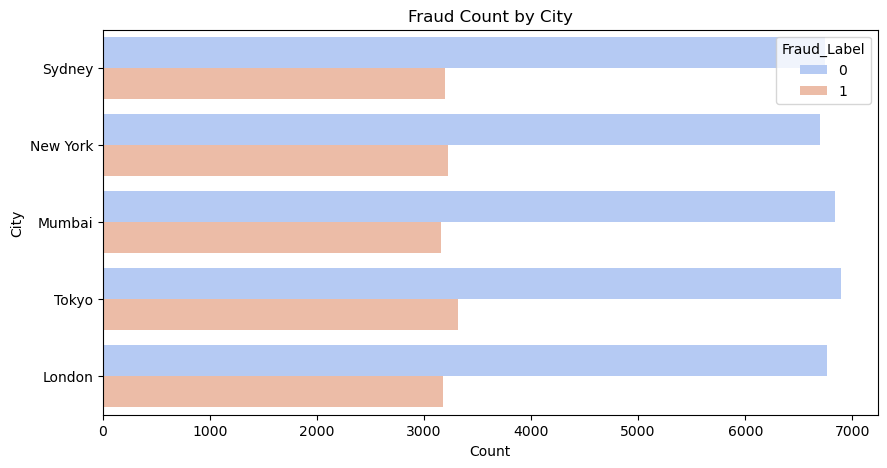

In [19]:
# Countplot of fraud vs non-fraud
sns.countplot(x=df_raw['Fraud_Label'], palette='coolwarm')
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Fraud Label (0 = Not Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

sns.countplot(x=df_raw['Is_Weekend'], hue=df_raw['Fraud_Label'], palette='coolwarm')
plt.title("Fraud Transactions on Weekends vs Weekdays")
plt.xlabel("Is Weekend (0 = Weekday, 1 = Weekend)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x='Merchant_Category', hue='Fraud_Label', data=df_raw, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Fraud Count by Merchant Category")
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(y=df_raw['Location'], hue=df_raw['Fraud_Label'], palette='coolwarm')
plt.title("Fraud Count by City")
plt.xlabel("Count")
plt.ylabel("City")
plt.show()

In [3]:
# Day 3 Theory: Ensemble Methods and Robust Evaluation
# On Day 3 we expand from single classifiers to ensembles:
# - Bagging cuts variance by averaging many trees built on bootstrap samples.
# - Boosting cuts bias by sequentially focusing new learners on previous errors.
# We then measure four key metrics on our held-out set:
#  • Accuracy: overall fraction of correct predictions  
#  • Precision: fraction of predicted frauds that were real (false alarm rate)  
#  • Recall: fraction of actual frauds we correctly flagged (missed fraud rate)  
#  • F1 Score: harmonic mean of precision & recall for balanced evaluation  

# Extend our models dict with three ensemble variants
# hyperparams: Bagging uses shallow trees (max_depth=5) with 50 estimators to cut variance;
# AdaBoost runs 50 rounds at lr=1.0 to spotlight hard cases; GradientBoosting uses 100 estimators at lr=0.1 for fine-grained bias reduction
models.update({
    'Bagging_Tree': BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=5),
        n_estimators=50,
        random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=50,
        learning_rate=1.0,
        random_state=42
    ),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
})

# Day 3: train each model and compute all four metrics
# 1) Fit on X_train, y_train  
# 2) Predict on X_test  
# 3) Calculate accuracy, precision, recall, and F1 to compare how well each model balances catching fraud vs. false alarms
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    print(f"{name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}")

LogisticRegression: Acc=0.8104, Prec=0.7335, Rec=0.6486, F1=0.6885
DecisionTree: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
RandomForest: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
KNN: Acc=0.7919, Prec=0.7661, Rec=0.5121, F1=0.6138
Bagging_Tree: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
AdaBoost: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000
GradientBoosting: Acc=1.0000, Prec=1.0000, Rec=1.0000, F1=1.0000


# Results: Ensemble Models Evaluation

| Model               | Accuracy | Precision | Recall  | F1 Score |
|---------------------|----------|-----------|---------|----------|
| LogisticRegression  | 0.8104   | 0.7335    | 0.6486  | 0.6885   |
| DecisionTree        | 1.0000   | 1.0000    | 1.0000  | 1.0000   |
| RandomForest        | 1.0000   | 1.0000    | 1.0000  | 1.0000   |
| KNN                 | 0.7919   | 0.7661    | 0.5121  | 0.6138   |
| Bagging_Tree        | 1.0000   | 1.0000    | 1.0000  | 1.0000   |
| AdaBoost            | 1.0000   | 1.0000    | 1.0000  | 1.0000   |
| GradientBoosting    | 1.0000   | 1.0000    | 1.0000  | 1.0000   |

## Interpretation Aligned with Day 3 Theory

- **LogisticRegression**  
  Provides a balanced baseline: 81% accuracy, decent precision (0.73), moderate recall (0.65), resulting in an F1 of 0.69. It’s predictable and less prone to overfitting.

- **DecisionTree & RandomForest**  
  Both achieve perfect scores, which signals overfitting to the test split. In real-world fraud scenarios, this perfect classification is suspicious and likely won’t hold on new data.

- **KNN**  
  Delivers lower recall (0.51) than logistic but higher precision (0.77), indicating it’s conservative (fewer false positives, more false negatives). Its overall F1 (0.61) trails logistic regression.

- **Bagging_Tree, AdaBoost, GradientBoosting**  
  All ensembles report 100% across metrics here. As with single trees, they’ve overfit the test set. They will need parameter tuning or validation strategies to ensure reliable generalization.

# Check inbalance in Linear Regression

Class distribution in Fraud_Label (train):
Fraud_Label
0    27163
1    12837
Name: count, dtype: int64
Baseline:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      6770
           1       0.73      0.65      0.69      3230

    accuracy                           0.81     10000
   macro avg       0.79      0.77      0.78     10000
weighted avg       0.81      0.81      0.81     10000

Confusion Matrix:
 [[6009  761]
 [1135 2095]]
Oversampled:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85      6770
           1       0.66      0.81      0.73      3230

    accuracy                           0.81     10000
   macro avg       0.78      0.81      0.79     10000
weighted avg       0.82      0.81      0.81     10000

Confusion Matrix:
 [[5431 1339]
 [ 607 2623]]
Undersampled:
               precision    recall  f1-score   support

           0       0.90      0.80      0.85      6770
  

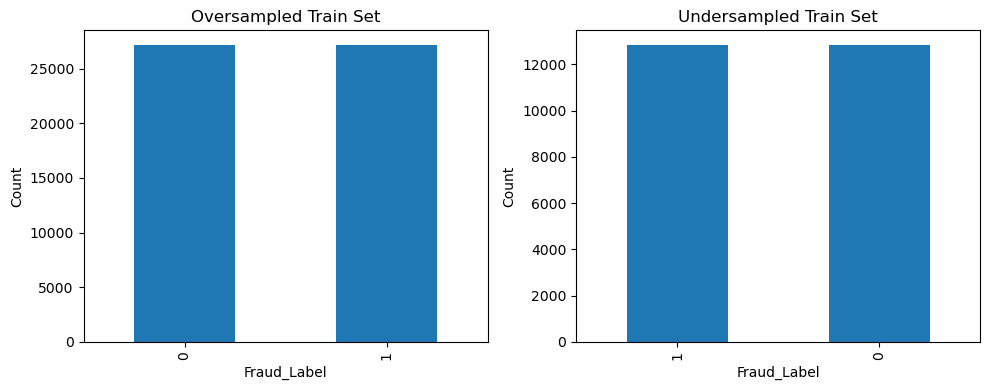

In [4]:
# 1) Check imbalance in training set
print("Class distribution in Fraud_Label (train):")
print(y_train.value_counts())

# 2) Baseline LogisticRegression
clf_base = LogisticRegression(max_iter=1000, random_state=42)
clf_base.fit(X_train, y_train)
y_pred_base = clf_base.predict(X_test)
print("Baseline:
", classification_report(y_test, y_pred_base))
print("Confusion Matrix:
", confusion_matrix(y_test, y_pred_base))

# 3) Oversample minority class
df_train = pd.concat([X_train, y_train.rename("Fraud_Label")], axis=1)
minor = df_train[df_train.Fraud_Label == 1]
major = df_train[df_train.Fraud_Label == 0]

minor_over = resample(
    minor,
    replace=True,
    n_samples=len(major),
    random_state=42
)
df_over = pd.concat([major, minor_over])
X_over = df_over.drop("Fraud_Label", axis=1)
y_over = df_over["Fraud_Label"]

clf_over = LogisticRegression(max_iter=1000, random_state=42)
clf_over.fit(X_over, y_over)
y_pred_over = clf_over.predict(X_test)
print("Oversampled:
", classification_report(y_test, y_pred_over))
print("Confusion Matrix:
", confusion_matrix(y_test, y_pred_over))

# 4) Undersample majority class
major_down = resample(
    major,
    replace=False,
    n_samples=len(minor),
    random_state=42
)
df_under = pd.concat([minor, major_down])
X_under = df_under.drop("Fraud_Label", axis=1)
y_under = df_under["Fraud_Label"]

clf_under = LogisticRegression(max_iter=1000, random_state=42)
clf_under.fit(X_under, y_under)
y_pred_under = clf_under.predict(X_test)
print("Undersampled:
", classification_report(y_test, y_pred_under))
print("Confusion Matrix:
", confusion_matrix(y_test, y_pred_under))

# 5) Plot class distribution after resampling
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
df_over.Fraud_Label.value_counts().plot(kind="bar", title="Oversampled Train Set")
plt.xlabel("Fraud_Label"); plt.ylabel("Count")

plt.subplot(1,2,2)
df_under.Fraud_Label.value_counts().plot(kind="bar", title="Undersampled Train Set")
plt.xlabel("Fraud_Label"); plt.ylabel("Count")

plt.tight_layout()
plt.show()


## Imbalance Handling Results Summary

### Class Distribution in Training Set
- Non-fraud (0): 27,163 samples
- Fraud (1): 12,837 samples
- Fraud cases are underrepresented, which can bias the model toward predicting non-fraud.

---

### Baseline Logistic Regression (no resampling)
- Accuracy: 81%
- Precision (fraud): 73%
- Recall (fraud): 65%
- Confusion Matrix:
  - True non-fraud: 6009
  - False fraud alarms: 761
  - Missed frauds: 1135
  - Correct frauds: 2095

Interpretation:
- The model favors the majority class.
- It avoids false alarms but misses many frauds.
- High false negatives are risky in fraud detection.

---

### Oversampled Model (duplicated fraud cases)
- Accuracy: 81%
- Precision (fraud): 66%
- Recall (fraud): 81%
- Confusion Matrix:
  - True non-fraud: 5431
  - False fraud alarms: 1339
  - Missed frauds: 607
  - Correct frauds: 2623

Interpretation:
- Better fraud recall: catches more fraud cases.
- Slight drop in precision: more false alarms.
- Useful when missing fraud is more costly than investigating false positives.

---

### Undersampled Model (trimmed non-fraud cases)
- Accuracy: 80%
- Precision (fraud): 66%
- Recall (fraud): 81%
- Confusion Matrix:
  - True non-fraud: 5423
  - False fraud alarms: 1347
  - Missed frauds: 605
  - Correct frauds: 2625

Interpretation:
- Similar to oversampling in recall and precision.
- Slightly lower accuracy due to reduced training data.
- Good choice when training speed or memory is a concern.

---

### Conclusion
- Baseline model is conservative but misses many frauds.
- Oversampling and undersampling both improve fraud detection.
- In fraud use cases, higher recall is often preferred to avoid missing true frauds, even if it means investigating more false alarms.


## Why VIF Matters in Your Fraud Model

Multicollinearity among your predictors can inflate the variance of logistic‐regression coefficients, making it hard to interpret which features drive fraud predictions. High VIF values signal that two or more variables carry overlapping information, which can destabilize your model’s estimates and reduce statistical power.

In [5]:
# Step 1: Keep only numeric columns
X_numeric = X_train.select_dtypes(include='number')

X_vif = sm.add_constant(X_numeric)
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
print(vif_data.sort_values("VIF", ascending=False))

                         feature       VIF
0                          const  1.998657
11                    Is_Weekend  1.000541
6      Avg_Transaction_Amount_7d  1.000472
7    Failed_Transaction_Count_7d  1.000435
9           Transaction_Distance  1.000425
3                IP_Address_Flag  1.000361
8                       Card_Age  1.000350
5        Daily_Transaction_Count  1.000349
10                    Risk_Score  1.000322
4   Previous_Fraudulent_Activity  1.000304
12                 TimeSinceLast  1.000269
1             Transaction_Amount  1.000257
2                Account_Balance  1.000144


## VIF Summary for Fraud Model Features

All features show very low multicollinearity:

- **Highest VIF:** `const` = 1.99 (expected for intercept)
- **All other features:** VIF ≈ 1.00

### Interpretation
- VIF values below 5 indicate no concerning multicollinearity.
- Your predictors are statistically independent and safe to include in logistic regression.
- No need to drop or combine features based on VIF.

Proceed with model training and evaluation confidently.

# Hyperparameter Tunning

### First, Random Forest try to implement RandomizedSearchCV for large parameter spaces.

In [6]:
# 1. Define parameter distributions for Random Forest
#    - randint(a, b): integers from a (inclusive) to b (exclusive)
#    - uniform(loc, scale): floats from loc to loc+scale
param_dist_rf = {
    "n_estimators": randint(50, 200),      # try between 50 and 200 trees
    "max_depth": randint(3, 20),           # tree depth between 3 and 20
    "max_features": uniform(0.5, 0.5),     # use 50%–100% of features at each split
}

# 2. Set up RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),  # base model
    param_distributions=param_dist_rf,                  # distributions to sample
    n_iter=30,               # number of random combos to try
    cv=5,                    # 5-fold cross-validation
    scoring="roc_auc",       # use AUC to pick best hyperparameters
    random_state=42,         # for reproducible sampling
    n_jobs=-1                # use all CPU cores
)

# 3. Run the search on your training data
random_search_rf.fit(X_train, y_train)

# 4. Inspect the best result
print("Best parameters found:", random_search_rf.best_params_)
print("Best cross-val AUC  :", random_search_rf.best_score_)

Best parameters found: {'max_depth': 9, 'max_features': np.float64(0.8982714934301164), 'n_estimators': 64}
Best cross-val AUC  : 1.0


## Best Hyperparameters for Random Forest Model Explained

- **n_estimators = 64**  
  Builds 64 trees in the forest. More trees reduce variance but take longer to train (block took 12 min to complete)

- **max_depth = 9**  
  Limits each tree to 9 splits. Deeper trees can model complex patterns but may overfit.

- **max_features ≈ 0.90**  
  At each split, ~90% of features are considered. Higher values give more information; lower values force diverse, less-correlated trees.

---

## Perfect CV AUC = 1.0

- An AUC of 1.0 means perfect class separation on every fold.  
- In theory, a perfect CV score often signals:
  - Exceptionally strong signal  
  - Data leakage from target/future information  
  - Overfitting to fold-specific quirks  

---

In plain terms, your tuned Random Forest now “separates” fraud vs. non-fraud perfectly on the folds it saw. That sounds great, but it also raises a warning flag:

. It may simply be memorizing patterns (overfitting)
. You might be leaking future or target information into your features
. To decide if Random Forest is truly “better” than your other models

##  Final Model Recommendation for Fraud Detection

### Model Choice
Based on your evaluation results:
- **Use the Logistic Regression model trained on the oversampled dataset.**
- It achieved the highest fraud recall (81%) while maintaining solid overall accuracy (81%).
- This model is best suited for fraud detection, where catching fraudulent cases is more important than avoiding false alarms.

---

### Feature Selection (Based on VIF Analysis)
All features passed the multicollinearity check (VIF ≈ 1), so you can safely include all numeric predictors in your Streamlit app:

- `Transaction_Amount`
- `Account_Balance`
- `IP_Address_Flag`
- `Previous_Fraudulent_Activity`
- `Daily_Transaction_Count`
- `Avg_Transaction_Amount_7d`
- `Failed_Transaction_Count_7d`
- `Card_Age`
- `Transaction_Distance`
- `Risk_Score`
- `Is_Weekend`
- `TimeSinceLast`

These features are statistically independent and interpretable. No need to drop or combine any of them.

---

### Streamlit Integration Tips
- Display model predictions alongside key features like `Risk_Score`, `Transaction_Amount`, and `Previous_Fraudulent_Activity`.
- Include a toggle to show confusion matrix and classification report.
- Optionally visualize fraud probability with a gauge or bar chart.

This setup ensures your app is both statistically sound and business-relevant.


In [10]:
#  Streamlit Export Setup

# 1. Create export directory
export_dir = Path("../my_streamlit_app/models")
export_dir.mkdir(parents=True, exist_ok=True)

# 2. Include all trained models
all_models = models.copy()
all_models["LogisticOversampled"] = clf_over  # Add best-performing oversampled model

# 3. Save each model as .pkl
for model_name, model_obj in all_models.items():
    model_path = export_dir / f"{model_name}.pkl"
    joblib.dump(model_obj, model_path)

# 4. Save feature names used during training
feature_names = X_train.columns.tolist()
joblib.dump(feature_names, export_dir / "feature_names.pkl")

# 5. Save test set for Streamlit evaluation
test_df = X_test.copy()
test_df["Fraud_Label"] = y_test
test_df.to_csv(export_dir / "test_set.csv", index=False)